In [1]:
from dataclasses import replace 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df=pd.read_csv("AAPL.csv")
df["date"]=pd.to_datetime(df["date"])
df["close"]=df["close"].astype(float)

# Prediction on Apple Stocks

We are observing and predicting the prices at the closing of the apple stocks.

In [224]:

df['SMA30']=df['close'].rolling(30).mean()
df.isna().sum()

Unnamed: 0      0
symbol          0
date            0
close           0
high            0
low             0
open            0
volume          0
adjClose        0
adjHigh         0
adjLow          0
adjOpen         0
adjVolume       0
divCash         0
splitFactor     0
SMA30          29
dtype: int64

<AxesSubplot:xlabel='date'>

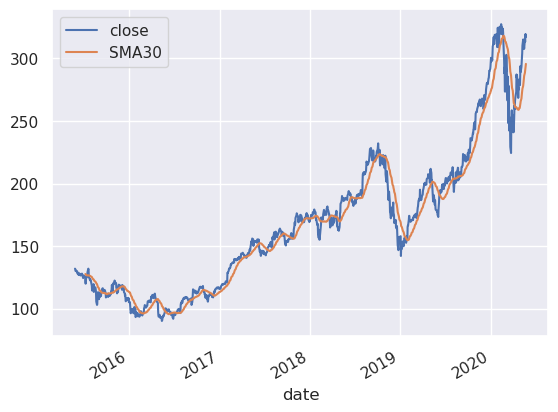

In [225]:
ax=plt.gca()

df.plot(kind='line',x='date',y='close', ax=ax)
df.plot(kind='line',x='date',y='SMA30', ax=ax)



When we plot the graph it seems to have a trend. But we can"t be sure by the seasonality. The data are not stationary so we can't use the ARIMA model. 

/tmp/ipykernel_6081/4264477025.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df1=df.resample("M",on='date').mean()


                           Unnamed: 0       close        high         low  \
date                                                                        
2015-05-31 00:00:00+00:00         1.0  131.368333  131.886667  130.350000   
2015-06-30 00:00:00+00:00        13.5  127.806364  128.761136  127.240645   
2015-07-31 00:00:00+00:00        35.5  125.335455  126.203518  124.340000   
2015-08-31 00:00:00+00:00        57.0  113.394762  115.500000  111.290476   
2015-09-30 00:00:00+00:00        78.0  112.797619  114.207262  111.523624   
2015-10-31 00:00:00+00:00        99.5  113.360000  114.132336  111.875227   
2015-11-30 00:00:00+00:00       120.5  118.162250  119.272000  117.256550   
2015-12-31 00:00:00+00:00       141.5  111.726818  113.021364  110.741941   
2016-01-31 00:00:00+00:00       162.0   98.428947   99.949295   96.928416   
2016-02-29 00:00:00+00:00       181.5   95.746500   96.727680   94.711550   
2016-03-31 00:00:00+00:00       202.5  104.267273  104.897268  103.231368   

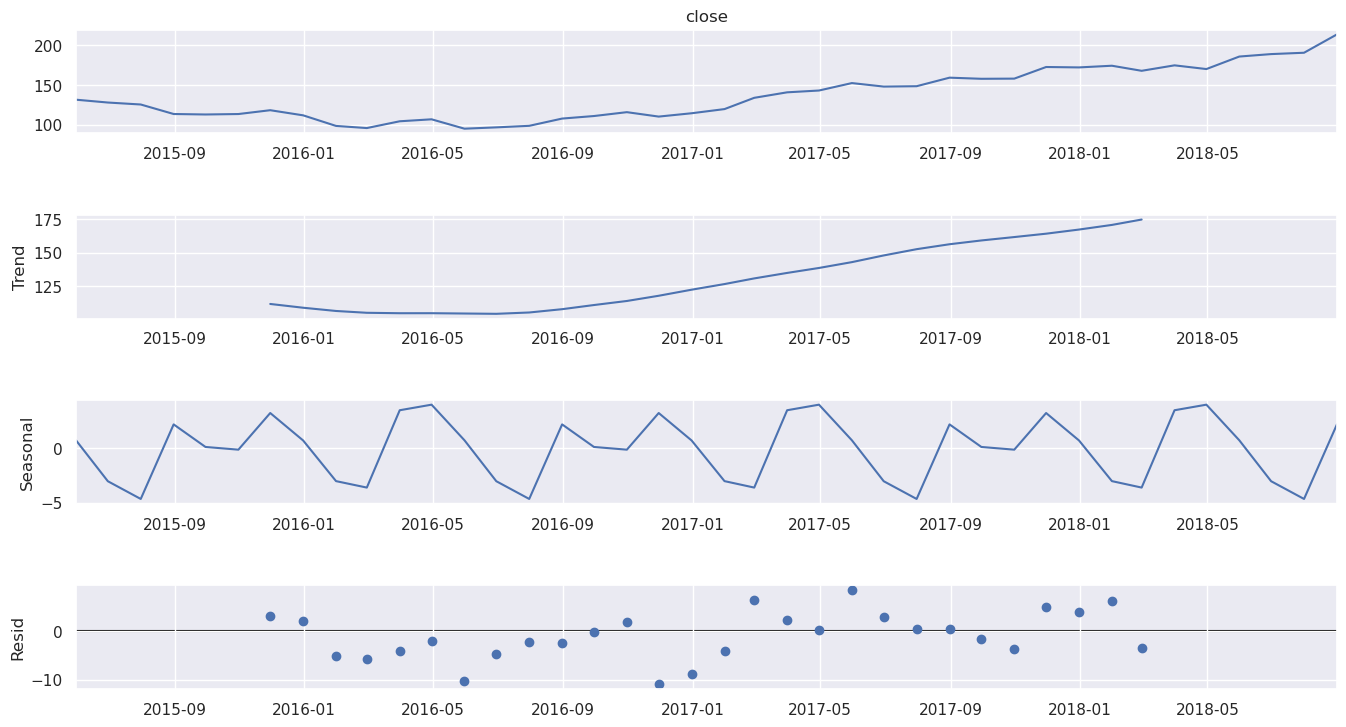

In [226]:
from statsmodels.tsa.seasonal import seasonal_decompose
df1=df.resample("M",on='date').mean()
df_train=df1[0:40]
df_test=df1[40:61]
print(df_train)

decomp= seasonal_decompose(df_train["close"])
fig1=decomp.plot()
fig1.set_size_inches(15,8)



Here, we are decomposing our time serie. We can clearly observe an increasing trend. Also, we can see that there is a seasonality on the year.

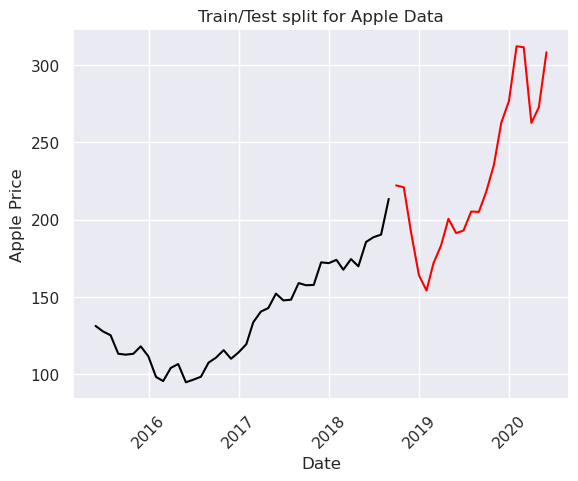

In [227]:
plt.plot(df_train["close"], color = "black")
plt.plot(df_test["close"], color = "red")
plt.ylabel('Apple Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for Apple Data")
plt.show()

We are spliting our dataset to see if our training is right.

Let's apply ARIMA model to forecast apple price. First we have to identify and then remove the trend. 

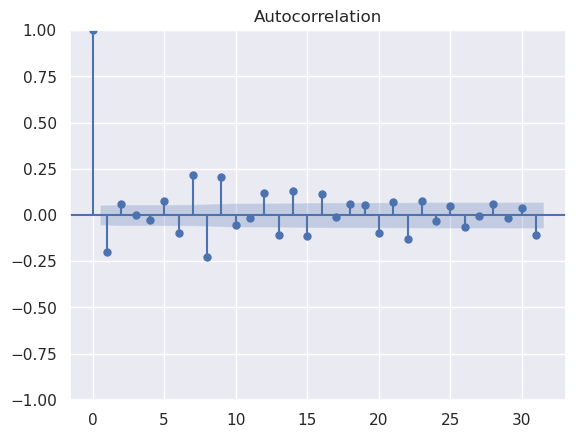

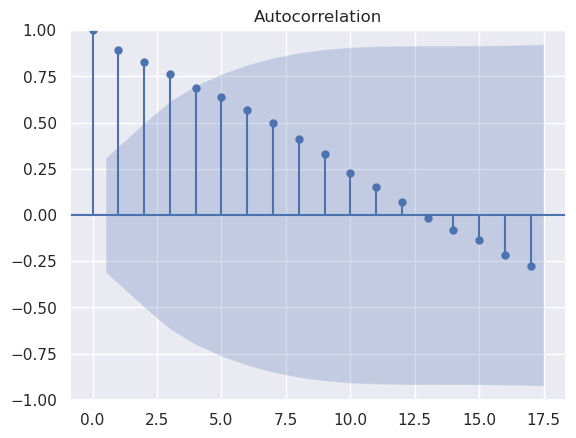

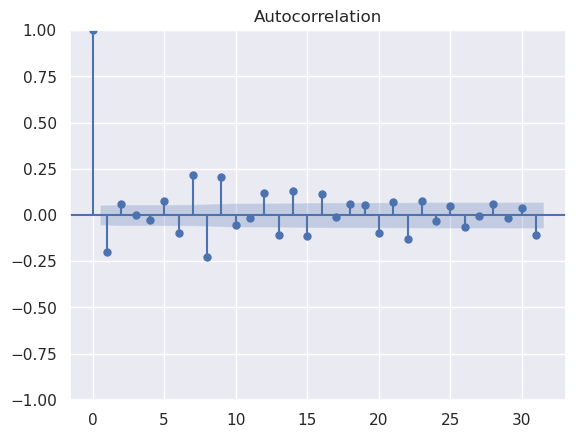

In [236]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df_train["close"])

f=plt.figure()
ax1=f.add_subplot()
plot_acf(df['close'].diff().dropna(),ax=ax1)

The residual are significant here. There is not seasonality. There is many point who have autocorrelation. 

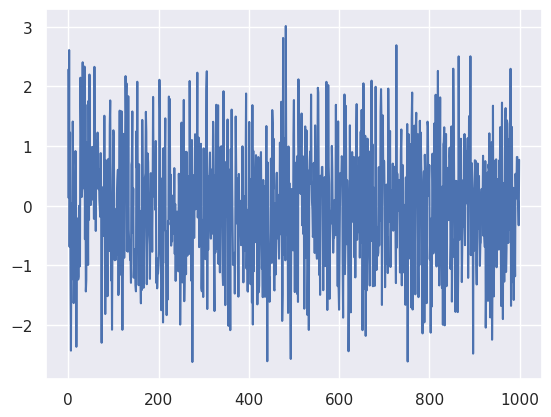

In [242]:
white_noise = np.random.normal(loc=0, scale=1, size=1000)

plt.plot(white_noise)

We can see that there is a white noise.

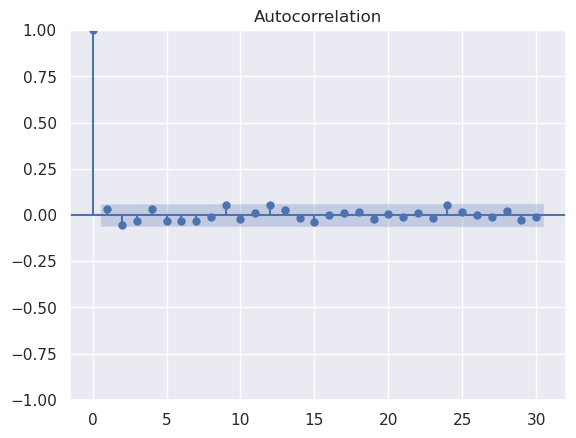

In [244]:
plot_acf(white_noise,lags=30)
plt.show()

So we can define the order of our ARIMA model 

In [229]:
from statsmodels.tsa.arima.model import ARIMA
out_put=df_train["close"]

In [230]:
ARIMAmodel = ARIMA(out_put, order = (0, 2, 1))
ARIMAmodel = ARIMAmodel.fit()

y_pred = ARIMAmodel.get_forecast(len(df_test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARIMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = df_test.index
y_pred_out = y_pred_df["Predictions"] 

import numpy as np
from sklearn.metrics import mean_squared_error

arma_rmse = np.sqrt(mean_squared_error(df_test["close"].values, y_pred_df["Predictions"]))
print("RMSE: ",arma_rmse)

RMSE:  61.39909712220947


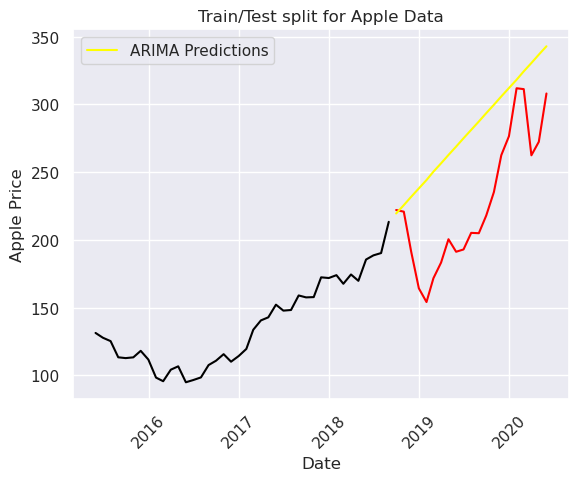

In [231]:
import seaborn as sns
sns.set()
plt.plot(df_train["close"], color = "black")
plt.plot(df_test["close"], color = "red")
plt.ylabel('Apple Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for Apple Data")
plt.plot(y_pred_out, color='Yellow', label = 'ARIMA Predictions')
plt.legend()
plt.show()

We can clearly see that the prediction is right even if you don't have the residuals.

In [232]:
y_pred_out

date
2018-09-30 00:00:00+00:00    219.515142
2018-10-31 00:00:00+00:00    225.684197
2018-11-30 00:00:00+00:00    231.853252
2018-12-31 00:00:00+00:00    238.022307
2019-01-31 00:00:00+00:00    244.191362
2019-02-28 00:00:00+00:00    250.360417
2019-03-31 00:00:00+00:00    256.529472
2019-04-30 00:00:00+00:00    262.698527
2019-05-31 00:00:00+00:00    268.867582
2019-06-30 00:00:00+00:00    275.036637
2019-07-31 00:00:00+00:00    281.205692
2019-08-31 00:00:00+00:00    287.374747
2019-09-30 00:00:00+00:00    293.543802
2019-10-31 00:00:00+00:00    299.712857
2019-11-30 00:00:00+00:00    305.881912
2019-12-31 00:00:00+00:00    312.050967
2020-01-31 00:00:00+00:00    318.220022
2020-02-29 00:00:00+00:00    324.389077
2020-03-31 00:00:00+00:00    330.558132
2020-04-30 00:00:00+00:00    336.727187
2020-05-31 00:00:00+00:00    342.896242
Freq: M, Name: Predictions, dtype: float64

In [233]:
import pmdarima as pm

model = pm.auto_arima(df_train["close"], start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=287.508, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=280.547, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=285.690, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=277.232, Time=0.05 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=274.558, Time=0.07 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=273.467, Time=0.05 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=275.717, Time=0.04 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=271.306, Time=0.07 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=270.036, Time=0.07 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=268.893, Time=0.05 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=267.230, Time=0.04 se

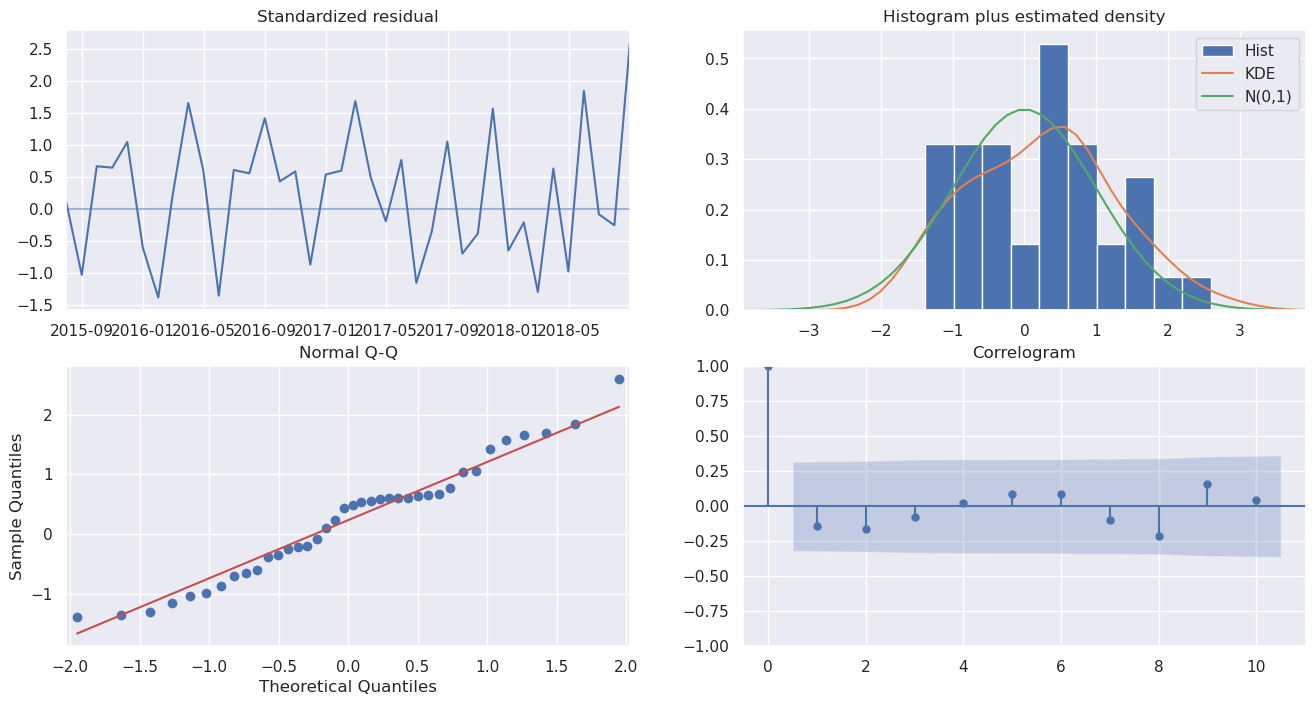

In [234]:
model.plot_diagnostics(figsize=(16,8))
plt.show()

The residual errors seem to fluctuate around a mean of zero and have a uniform variance between (-1.5, 2.5).

The density plot don't really suggest normal distribution with mean zero

The most part of the blue dots are over the red line, so it seems that the distribution in very low skewed

he Correlogram, aka, ACF plot shows the residual errors are autocorrelated.